# Merge Data

> This notebook was made to demonstrate how to merge datasets by matching a single columns values from two datasets. We add columns of data from a foreign dataset into the ACS data we downloaded in our last tutorial.

This Coding Notebook is the __second__ in a series.

An Interactive version can be found here <a href="https://colab.research.google.com/github/BNIA/colabs/blob/master/02_Merge_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>.


This colab and more can be found at https://github.com/BNIA/colabs

- Content covered in previous tutorials will be used in later tutorials. 

- __new code and or  information *should* have explanations and or descriptions__ attached. 

- Concepts or code covered in previous tutorials will be used without being explaining in entirety.

- __If content can not be found in the current tutorial and is not covered in previous tutorials, please let me know.__

- This notebook has been optimized for Google Colabs ran on a Chrome Browser. 

- statements made in light of view expressed, responsibility, errors and ommissions, use at risk, and licensing from part one of this tutorial extend throughout.

## About this Tutorial: 

### Before we begin

### Whats Inside?

#### __The Tutorial__

This notebook was made to demonstrate how to merge datasets by matching a single columns values from two datasets.

#### __Objectives__

By the end of this tutorial users should have an understanding of:
- How dataset merges are performed
- The types different union approaches a merge can take
- the 'mergeData' function, and how to use it in the future

# Guided Walkthrough

## SETUP

In [0]:
#@title Import Modules

%%capture 

# These imports will handle everything
import os
import sys
import csv
import numpy as np
import pandas as pd

### Configure Enviornment

In [0]:
# This will just beautify the output

pd.set_option('max_colwidth', 20)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

### (Optional) Local File Access

In [0]:
# (Optional) Run this cell to gain access to Google Drive (Colabs only) 
from google.colab import drive

# Colabs operates in a virtualized enviornment
# Colabs default directory is at ~/content.
# We mount Drive into a temporary folder at '~/content/drive' 

drive.mount('/content/drive')

In [0]:
# Once connected, I navigate to where the data lives in my drive folder.

!cd ../../../drive/'My Drive'/colabs/DATA

## Retrieve Datasets

Our example will merge two simple datasets; pulling CSA names using tract ID's.

The First dataset will be obtained from the Census' ACS 5-year serveys. 

Functions used to obtain this data were obtained from Tutorial 0) ACS: Explore and Download. 

The Second dataset will be obtained using using a CSV from a publicly accessible link

### Get the Principal dataset.

The following two scripts will load required code and create the required functions to download ACS data. 

More information on this section can be found in the previous tutorial denoted above.

In [0]:
#@title Run This Cell: Import Modules

%%capture 
# ^ will hide unruly the output so as not to confuse users

# Install the Widgets Module. 
# Colabs does not locally provide this Python Library
# The '!' is a special prefix used in colabs when talking to the terminal
!pip install -U -q ipywidgets
!pip install geopandas

# Once installed we need to import and configure the Widgets
import ipywidgets as widgets
!jupyter nbextension enable --py widgetsnbextension
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Used 4 Importing Data
import urllib.request as urllib 
from urllib.parse import urlencode 
# This Prevents Timeouts when Importing
import socket 
socket.setdefaulttimeout(10.0)

# Pandas Data Manipulation Libraries
import pandas as pd
# Show entire column widths
pd.set_option('display.max_colwidth', -1)
# 4 Working with Json Data
import json 
# 4 Data Processing
import numpy as np
# 4 Reading Json Data into Pandas
from pandas.io.json import json_normalize

# 4 exporting data as CSV
import csv


# Geo-Formatting
# Postgres-Conversion
import geopandas as gpd
from geopandas import GeoDataFrame
import psycopg2,pandas,numpy
from shapely import wkb
from shapely.wkt import loads
import os
import sys

# In case file is KML
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts

# load libraries
#from shapely.wkt import loads
#from pandas import ExcelWriter
#from pandas import ExcelFile
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import imageio

In [0]:
# @title Run: Create retrieve_acs_data()

#File: retrieveAcsData.py
#Author: Charles Karpati
#Date: 1/9/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description:
#This file returns ACS data given an ID and Year
# The county total is given a tract of '010000'

#def retrieve_acs_data():
#purpose: Retrieves ACS data from the web
#input: 
# state (required) 
# county (required) 
# tract (required) 
# tableId (required)
# year (required)
# includeCountyAgg (required)(todo) 
# saveAcs (required) 
#output: 
# Acs Data. 
# Prints to ../../data/2_cleaned/acs/

dictionary = ''
def retrieve_acs_data(state, county, tract, tableId, year, saveAcs):
    keys = []
    vals = []
    header = []
    keys1=keys2=keys3=keys4=keys5=keys6=keys7=keys8=''
    keyCount = 0

    # Called in addKeys(), Will create the final URL for readIn()
    # These are parameters used in the API URL Query
    # This query will retrieve the census tracts
    def getParams(keys): return {
        'get': 'NAME'+keys,
        'for': 'tract:'+tract,
        'in': 'state:'+state+' county:'+county,
        'key': '829bf6f2e037372acbba32ba5731647c5127fdb0'
      }
    # Aggregate City data is best retrieved seperatly rather than as an aggregate of its constituent tracts
    def getCityParams(keys): return {
        'get': 'NAME'+keys,
        'for': 'county:'+county,
        'in': 'state:'+state,
        'key': '829bf6f2e037372acbba32ba5731647c5127fdb0'
      }
    # Called in AddKeys(). Requests data by url and preformats it.
    def readIn( url ):
        tbl = pd.read_json(url, orient='records')
        tbl.columns = tbl.iloc[0]
        return tbl 

    # Called by retrieveAcsData. 
    # Creates a url and retrieve the data
    # Then appends the city values as tract '010000'
    # Finaly it merges and returns the tract and city totals.
    def addKeys( table, params):
        # Get Tract and City Records For Specific Columns
        table2 = readIn( base+urlencode(getParams(params)) )
        table3 = readIn( base+urlencode(getCityParams(params)) )
        table3['tract'] = '010000'
        # Concatenate the Records
        table2.append([table2, table3], sort=False)
        table2 = pd.concat([table2, table3], ignore_index=True)
        # Merge to Master Table
        table = pd.merge(table, table2,  how='left', 
                         left_on=["NAME","state","county","tract"], 
                         right_on = ["NAME","state","county","tract"])
        return table
    
    #~~~~~~~~~~~~~~~
    # Step 1)
    # Retrieve a Meta Data Table Describing the Content of the Table
    #~~~~~~~~~~~~~~~
    url = 'https://api.census.gov/data/20'+year+'/acs/acs5/groups/'+tableId+'.json'
    metaDataTable = pd.read_json(url, orient='records')
    
    #~~~~~~~~~~~~~~~
    # Step 2)
    # Createa a Dictionary using the Meta Data Table
    #~~~~~~~~~~~~~~~
    # Multiple Queries may be Required.
    # Max columns returned from any given query is 50.
    # For that reasons bin the Columns into Groups of 50.
    for key in metaDataTable['variables'].keys():
      if key[-1:] == 'E':
        keyCount = keyCount + 1
        if keyCount < 40 : keys1 = keys1+','+key
        elif keyCount < 80 : keys2 = keys2+','+key
        elif keyCount < 120 : keys3 = keys3+','+key
        elif keyCount < 160 : keys4 = keys4+','+key
        elif keyCount < 200 : keys5 = keys5+','+key
        elif keyCount < 240 : keys6 = keys6+','+key
        elif keyCount < 280 : keys7 = keys7+','+key
        elif keyCount < 320 : keys8 = keys8+','+key
        keys.append(key)
        val = metaDataTable['variables'][key]['label']
        # Column name formatting
        val = key+'_'+val.replace('Estimate!!', '').replace('!!', '_').replace(' ', '_')
        vals.append(val)
    dictionary = dict(zip(keys, vals))
  
    #~~~~~~~~~~~~~~~
    # Step 2)
    # Get the actual Table with the data we want using 
    #~~~~~~~~~~~~~~~    
    
    # The URL we call is contingent on if the Table we want is a Detailed or Subject table
    url1 = 'https://api.census.gov/data/20'+year+'/acs/acs5?'
    url2 = 'https://api.census.gov/data/20'+year+'/acs/acs5/subject?'
    base = ''
    if tableId[:1] == 'B': base = url1 
    if tableId[:1] == 'S': base = url2
      
    # The addKey function only works after the first set of columns has been downloaded
    # Download First set of Tract columns
    url = base+urlencode(getParams(keys1) )
    table = pd.read_json(url, orient='records')
    table.columns = table.iloc[0]
    table = table.iloc[1:]
    # Download First set of Aggregate City data 
    url = base+urlencode(getCityParams(keys1))
    table2 = pd.read_json(url, orient='records')
    table2.columns = table2.iloc[0]
    table2 = table2[1:]
    table2['tract'] = '010000'
    
    # Merge EM
    #table = pd.concat([table, table2], keys=["NAME","state","county",], axis=0)
    table.append([table, table2], sort=False)
    table = pd.concat([table, table2], ignore_index=True)
    
    # Now we can repetedly use this function to add as many columns as there are keys listed from the meta data table
    if keys2 != '' : table = addKeys(table, keys2)
    if keys3 != '' : table = addKeys(table, keys3)
    if keys4 != '' : table = addKeys(table, keys4)
    if keys5 != '' : table = addKeys(table, keys5)
    if keys6 != '' : table = addKeys(table, keys6)
    if keys7 != '' : table = addKeys(table, keys7)
    if keys8 != '' : table = addKeys(table, keys8)
      
    #~~~~~~~~~~~~~~~
    # Step 3)
    # Prepare Column Names using the meta data table. The raw data has columnsNames in the first row, as well.
    # Replace column ID's with labels from the dictionary where applicable (should be always)
    #~~~~~~~~~~~~~~~
    print('Number of Columns', len(dictionary) )

    header = []
    for column in table.columns:
        if column in keys: header.append(dictionary[column])
        else: header.append(column)
    table.columns = header

    # Prettify Names. Only happens with Baltimore...
    table['NAME'] = table['NAME'].str.replace(', Baltimore city, Maryland', '')
    table['NAME'][table['NAME'] == 'Baltimore city, Maryland'] = 'Baltimore City' 
    
    # Convert to Integers Columns from Strings where Applicable
    table = table.apply(pd.to_numeric, errors='ignore')
    
    # Set the 'NAME' Column as the index dropping the default increment
    table.set_index("NAME", inplace = True)
    
    if saveAcs:
      # Save the raw data as 'TABLEID_5yYEAR.csv'
      table.to_csv('./'+state+county+'_'+tableId+'_5y'+year+'_est_Original.csv', quoting=csv.QUOTE_ALL)
      # Remove the id in the column names & Save the data as 'TABLEID_5yYEAR_est.csv'
      saveThis = table.rename( columns = lambda x : ( str(x)[:] if str(x) in [
        "NAME","state","county","tract"] else str(x)[12:] )  )
      saveThis.to_csv('./'+state+county+'_'+tableId+'_5y'+year+'_est.csv', quoting=csv.QUOTE_ALL)

    return table

Now use this function to Download the Data!

In [0]:
# Our download function will use Baltimore City's tract, county and state as internal paramters
# Change these values in the cell below using different geographic reference codes will change those parameters
tract = '*'
county = '510'
state = '24'

# Specify the download parameters the function will receieve here
tableId = 'B19001'
year = '17'
saveAcs = True

In [0]:
df = retrieve_acs_data(state, county, tract, tableId, year, saveAcs)
df.head()

Number of Columns 17


,B19001_001E_Total,B19001_002E_Total_Less_than_$10_000,B19001_003E_Total_$10_000_to_$14_999,B19001_004E_Total_$15_000_to_$19_999,B19001_005E_Total_$20_000_to_$24_999,B19001_006E_Total_$25_000_to_$29_999,B19001_007E_Total_$30_000_to_$34_999,B19001_008E_Total_$35_000_to_$39_999,B19001_009E_Total_$40_000_to_$44_999,B19001_010E_Total_$45_000_to_$49_999,B19001_011E_Total_$50_000_to_$59_999,B19001_012E_Total_$60_000_to_$74_999,B19001_013E_Total_$75_000_to_$99_999,B19001_014E_Total_$100_000_to_$124_999,B19001_015E_Total_$125_000_to_$149_999,B19001_016E_Total_$150_000_to_$199_999,B19001_017E_Total_$200_000_or_more,state,county,tract
NAME,,,,,,,,,,,,,,,,,,,,
Census Tract 1901,796,237,76,85,38,79,43,36,35,15,43,45,39,5,0,6,14,24,510,190100
Census Tract 1902,695,63,87,93,6,58,30,14,29,23,38,113,70,6,32,11,22,24,510,190200
Census Tract 2201,2208,137,229,124,52,78,87,50,80,13,217,66,159,205,167,146,398,24,510,220100
Census Tract 2303,632,3,20,0,39,7,0,29,8,9,44,29,98,111,63,94,78,24,510,230300
Census Tract 2502.07,836,102,28,101,64,104,76,41,40,47,72,28,60,19,27,15,12,24,510,250207


### Get the Secondary Dataset

In [0]:
# Get the Second dataset. 
# Our Example dataset contains Polygon Geometry information. 
# We want to merge this over to our principle dataset. we will grab it by matching on either CSA or Tract

# The url listed below is public.

print('Crosswalk Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv')
print('Boundaries Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv')

inFile = input("\n Please enter the location of your file : \n" )

crosswalk = pd.read_csv( inFile )
crosswalk.head()

Crosswalk Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv
Boundaries Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv

 Please enter the location of your file : 
https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv


,TRACT2010,GEOID2010,CSA2010
0,10100,24510010100,Canton
1,10200,24510010200,Patterson Park North & East
2,10300,24510010300,Canton
3,10400,24510010400,Canton
4,10500,24510010500,Fells Point


## Perform Merge & Save

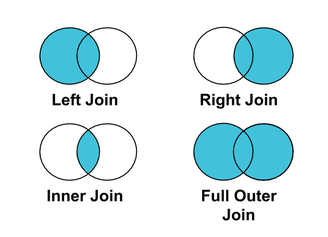

In [0]:
# This little piece of code does nothing important but serves as a 
# friendly reminder of the 4 basic join types.

# Left - returns all left records, only includes the right record if it has a match
# Right - Returns all right records, only includes the left record if it has a match 
# Full - Returns all records regardless of keys matching
# Inner - Returns only records where a key match

from PIL import Image
import requests
from io import BytesIO
url = "https://docs.trifacta.com/download/attachments/123830435/JoinVennDiagram.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
size = 328, 328
img.thumbnail(size, Image.ANTIALIAS)
img

In [0]:
# Get Columns from both datasets to match on
# You can get these values from the column values above.

# Our Examples will work with the prompted values

print( 'Princpal Columns ' + str(df.columns) + '')
left_on = input("Left on principal column: ('tract') \n" )

print( 'Crosswalk Columns ' + str(crosswalk.columns) + '')
right_on = input("Right on crosswalk column: ('TRACT2010', or, 'TRACTCE10') \n" )

# Specify how the merge will be performed

Princpal Columns Index(['B19001_001E_Total', 'B19001_002E_Total_Less_than_$10_000',
       'B19001_003E_Total_$10_000_to_$14_999',
       'B19001_004E_Total_$15_000_to_$19_999',
       'B19001_005E_Total_$20_000_to_$24_999',
       'B19001_006E_Total_$25_000_to_$29_999',
       'B19001_007E_Total_$30_000_to_$34_999',
       'B19001_008E_Total_$35_000_to_$39_999',
       'B19001_009E_Total_$40_000_to_$44_999',
       'B19001_010E_Total_$45_000_to_$49_999',
       'B19001_011E_Total_$50_000_to_$59_999',
       'B19001_012E_Total_$60_000_to_$74_999',
       'B19001_013E_Total_$75_000_to_$99_999',
       'B19001_014E_Total_$100_000_to_$124_999',
       'B19001_015E_Total_$125_000_to_$149_999',
       'B19001_016E_Total_$150_000_to_$199_999',
       'B19001_017E_Total_$200_000_or_more', 'state', 'county', 'tract'],
      dtype='object')
Left on principal column: ('TRACT2010') 
tract
Crosswalk Columns Index(['TRACT2010', 'GEOID2010', 'CSA2010'], dtype='object')
Right on crosswalk column: ('T

In [0]:
# We will perform a left merge in this example.
# It will return our Principal dataset with columns from the second dataset appended to records where their specified columns match.

how = input("How: (‘left’, ‘right’, ‘outer’, ‘inner’) " )

How: (‘left’, ‘right’, ‘outer’, ‘inner’) left


In [0]:
# Actually perfrom the merge

merged_df = pd.merge(df, crosswalk, left_on=left_on, right_on=right_on, how=how)
merged_df = merged_df.drop(left_on, axis=1)
merged_df

,B19001_001E_Total,B19001_002E_Total_Less_than_$10_000,B19001_003E_Total_$10_000_to_$14_999,B19001_004E_Total_$15_000_to_$19_999,B19001_005E_Total_$20_000_to_$24_999,B19001_006E_Total_$25_000_to_$29_999,B19001_007E_Total_$30_000_to_$34_999,B19001_008E_Total_$35_000_to_$39_999,B19001_009E_Total_$40_000_to_$44_999,B19001_010E_Total_$45_000_to_$49_999,B19001_011E_Total_$50_000_to_$59_999,B19001_012E_Total_$60_000_to_$74_999,B19001_013E_Total_$75_000_to_$99_999,B19001_014E_Total_$100_000_to_$124_999,B19001_015E_Total_$125_000_to_$149_999,B19001_016E_Total_$150_000_to_$199_999,B19001_017E_Total_$200_000_or_more,state,county,TRACT2010,GEOID2010,CSA2010
0,796,237,76,85,38,79,43,36,35,15,43,45,39,5,0,6,14,24,510,190100,24510190100,Southwest Baltimore
1,695,63,87,93,6,58,30,14,29,23,38,113,70,6,32,11,22,24,510,190200,24510190200,Southwest Baltimore
2,2208,137,229,124,52,78,87,50,80,13,217,66,159,205,167,146,398,24,510,220100,24510220100,Inner Harbor/Federal Hill
3,632,3,20,0,39,7,0,29,8,9,44,29,98,111,63,94,78,24,510,230300,24510230300,South Baltimore
4,836,102,28,101,64,104,76,41,40,47,72,28,60,19,27,15,12,24,510,250207,24510250207,Cherry Hill
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1219,84,41,42,72,39,94,69,38,41,87,124,107,40,91,93,157,24,510,272005,24510272005,Cross-Country/Cheswolde
197,883,78,27,31,3,33,31,30,43,23,52,96,133,65,67,53,118,24,510,120201,24510120201,Greater Charles Village/Barclay
198,1835,155,109,136,106,198,94,130,118,83,71,162,135,180,0,43,115,24,510,272004,24510272004,Cross-Country/Cheswolde
199,1679,347,165,130,125,64,78,80,25,50,168,99,166,70,54,29,29,24,510,272006,24510272006,Glen-Fallstaff


As you can see, our Census data will now have a CSA appended to it.

In [0]:
# Save Data to User Specified File

import csv

outFile = input("Please enter the new Filename to save the data to ('acs_csa_merge_test': " )
merged_df.to_csv(outFile+'.csv', quoting=csv.QUOTE_ALL) 

Please enter the new Filename to save the data to : merged_test


## Final Result

In [0]:
# Import needed modules
import os, sys, csv, pandas as pd

df = pd.read_csv( input("Please enter the location of your Principal file: " ) )
print( 'Principal Columns ' + str(df.columns))

print('Crosswalk Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv')
print('Boundaries Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv')

crosswalk = pd.read_csv( input("Please enter the location of your crosswalk file: " ) )
print( 'Crosswalk Columns ' + str(crosswalk.columns) + '\n')

left_on = input("Left on: " )
right_on = input("Right on: " )
how = input("How: (‘left’, ‘right’, ‘outer’, ‘inner’) " )

merged_df = pd.merge(df, crosswalk, left_on=left_on, right_on=right_on, how=how)
merged_df = merged_df.drop(left_on, axis=1)

# Save the data
# Save the data
saveFile = input("Save File ('Y' or 'N'): ")
if saveFile == 'Y' or saveFile == 'y':
  outFile = input("Saved Filename (Do not include the file extension ): ")
  merged_df.to_csv(outFile+'.csv', quoting=csv.QUOTE_ALL);

Please enter the location of your Principal file: 24510_B19001_5y17_est.csv
Principal Columns Index(['NAME', 'Total', 'Total_Less_than_$10_000', 'Total_$10_000_to_$14_999',
       'Total_$15_000_to_$19_999', 'Total_$20_000_to_$24_999',
       'Total_$25_000_to_$29_999', 'Total_$30_000_to_$34_999',
       'Total_$35_000_to_$39_999', 'Total_$40_000_to_$44_999',
       'Total_$45_000_to_$49_999', 'Total_$50_000_to_$59_999',
       'Total_$60_000_to_$74_999', 'Total_$75_000_to_$99_999',
       'Total_$100_000_to_$124_999', 'Total_$125_000_to_$149_999',
       'Total_$150_000_to_$199_999', 'Total_$200_000_or_more', 'state',
       'county', 'tract'],
      dtype='object')
Crosswalk Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv
Boundaries Example: https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv

# Advanced

__Intro__

The following Python function is a bulked out version of the previous notes. 
- It contains everything from the tutorial plus more.
- It can be imported and used in future projects or stand alone.

**Description:** add columns of data from a foreign dataset into a primary dataset along set parameters. 

**Purpose:** Makes Merging datasets simple

__Services__

- Merge two datasets without a crosswalk
- Merge two datasets with a crosswalk


In [0]:
#@title Run: Create mergeDatasets()

# Geometry_DS = https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv
# Data_DS = https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv

# Import needed modules
import os, sys, csv, pandas as pd, numpy as np 

def mergeDatasets(left_ds=False, 
                  right_ds=False, 
                  crosswalk_ds=False, 
                  use_crosswalk = True,
                  left_col=False, 
                  right_col=False, 
                  crosswalk_left_col = False, 
                  crosswalk_right_col = False, 
                  merge_how=False,
                  interactive=True): 
    
  # Decide to perform a merge or commit a pull
  def mergeOrPull(df, cw, left_on, right_on, how):  
    
    def merge(df, cw, left_on, right_on, how):
      df = pd.merge(df, cw, left_on=left_on, right_on=right_on, how=how)
      # df.drop(left_on, axis=1)
      df[right_on] = df[right_on].fillna(value='empty')
      return df

    def pull(df, cw, left_on, right_on, how):
      crswlk = dict(zip(cw[right_on], cw[how]  ) )
      dtype = df[left_on].dtype
      if dtype =='object':  df[how] = df.apply(lambda row: crswlk.get(str(row[left_on]), "empty"), axis=1)
      elif dtype == 'int64': 
        df[how] = df.apply(lambda row: crswlk.get(int(row[left_on]), "empty"), axis=1)
      return df
    
    mergeType = how in ['left', 'right', 'outer', 'inner']
    if mergeType: return merge(df, cw, left_on, right_on, how)
    else: return pull(df, cw, left_on, right_on, how)
    
  
    
  # Filter between matched records and not.
  def filterEmpties(df, cw, left_on, right_on, how, interactive):
    
    if how in ['left', 'right', 'outer', 'inner']: how = right_on
    nomatch = df.loc[df[how] == 'empty']
    nomatch = nomatch.sort_values(by=left_on, ascending=True)
    
    if nomatch.shape[0] > 0:
      # Do the same thing with our foreign tracts
      if(interactive): print('\n Local Column Values Not Matched ')
      if(interactive): print(nomatch[left_on].unique() )
      if(interactive): print(len(nomatch[left_on]))
      if(interactive): print('\n Crosswalk Unique Column Values')
      if(interactive): print(cw[right_on].unique() )
    
    # Create a new column with the tracts value mapped to its corresponding value from the crossswalk
    df[how].replace('empty', np.nan, inplace=True)
    df.dropna(subset=[how], inplace=True)
    # cw = cw.sort_values(by=how, ascending=True)
    return df

  # Check Crosswalk Params
  def handleCrosswalkDataset(crosswalk_ds, crosswalk_left_col, crosswalk_right_col, interactive):
    noDataset = (not isinstance(crosswalk_ds, pd.DataFrame))
    noColumns = (not crosswalk_left_col or not crosswalk_right_col)
    columnDne = checkColumns(crosswalk_ds, crosswalk_left_col)
    columnDne = checkColumns(crosswalk_ds, crosswalk_right_col)
    if ( noDataset or noColumns ): return mergeDatasets( *getMergeParams() );



  def handleMergeHow(right_ds, merge_how, interactive):
    howList = ['left', 'right', 'outer', 'inner'] 
    mergeHowInHowList = merge_how in howList
    mergeHowInRightDf = checkColumns(right_ds, merge_how)
    mergeHowExists = (mergeHowInRightDf or mergeHowInHowList)
    if ( mergeHowExists ): return merge_how
    elif ( not interactive): return False
    else: 
      try: 
        print('Valid Column Not Given');
        print("\n 1) Pull A single Column from the Right Dataset: ", right_ds.columns)
        print("OR");
        print("2) Join Operation: (‘left’, ‘right’, ‘outer’, ‘inner’, columnName) " )
        print("\n Please select a value from either list");
        merge_how = input("Column Name: " )
        return handleMergeHow(right_ds, merge_how, interactive);
      except: return handleMergeHow(right_ds, merge_how, interactive);



  def processColumn(df, col, interactive):
    # Check Column in Dataset 
    colExists = checkColumns(df, col)
    noColNotInteractive = not colExists and not interactive
    if colExists: return col
    elif (noColNotInteractive): return False
    else: 
        try: 
          print('Valid Column Not Given');
          print(df.columns)
          print(df.head())
          print("Please provide a dataset column name from the list above.");
          col = input("Column Name: " )
          colExists = checkColumns(df, col)
          if (colExists): return col
          else: return processColumn(df, col, interactive);
        except: return processColumn(df, col, interactive);






  # Returns a DF if provided a DF or URL. False otherwise. 
  def retrieveDatasetFromUrl(df):
    datasetExists = checkDataSetExists(df)
    urlGiven = df and not datasetExists
    if datasetExists: return df
    elif ( urlGiven ):
      try: 
        urlGiven = df
        df = pd.read_csv( df )
        datasetExists = checkDataSetExists(df)
        if datasetExists: return df
      except: return False;
    else: return False

  # If !DF and interactive, re-processDataset. False otherwise.
  def retrieveUrlForDataset(df, interactive):
    dsExists = checkDataSetExists(df)
    if( dsExists ): return df
    if ( not dsExists and not interactive): return False;
    if ( not dsExists and interactive): 
      df = input("Please provide a new dataset URL: " );
      return processDataset(df, interactive)

  # Ensures a Pandas DF is returned. 
  # If not Interactive, may return FALSE.
  def processDataset(df, interactive):
    # Returns a DF if provided a DF or URL. False otherwise. 
    df = retrieveDatasetFromUrl(df)
    # If !DF and interactive, re-processDataset w/a new URL
    df = retrieveUrlForDataset(df, interactive)
    return df





  # Check Dataset Params
  def handleDatasetAndColumns(df, col, interactive):
    dfStatus = colStatus = True
    # Ensure A Dataset is being handled
    df = processDataset(df, interactive)
    if ( not checkDataSetExists(df) ): dfStatus = False

    # Ensure A Column Exists
    col = processColumn(df, col, interactive)
    if ( col == False ): colStatus = False
    return df, col, dfStatus, colStatus




  # Ensure data types are the same
  def coerceDtypes(left_ds, right_ds, left_col, right_col, interactive):
    status = False
    foreignDtype = right_ds[right_col].dtype
    localDtype = left_ds[left_col].dtype  

    localIsNumber = localDtype == 'float64' or localDtype == 'int64'
    foreignIsNumber = foreignDtype == 'int64' or foreignDtype == 'int64'

    if foreignIsNumber: right_ds[right_col] = right_ds[right_col].fillna(-1321321321321325)
    if localIsNumber: left_ds[left_col] = left_ds[left_col].fillna(-1321321321321325)
    
    # Coerce one way or the other if possible
    if localIsNumber and foreignDtype == 'object':
      if(interactive): print('Converting Foreign Key from Object to Int' )
      right_ds[right_col] = pd.to_numeric(right_ds[right_col], errors='coerce')
      
    if localDtype == 'object' and foreignIsNumber:
      if(interactive):  print('Converting Foreign Key from Object to Int' )
      left_ds[left_col] = pd.to_numeric(left_ds[left_col], errors='coerce')

    # Coerce INTS AND FLOATS if possible        
    if localDtype == 'int64' and foreignDtype == 'float64':
      if(interactive): print('Converting Local Key from Int to float' )
      right_ds[right_col] = right_ds[right_col].astype(int)

    if localDtype == 'float64' and foreignDtype == 'int64':
      if(interactive): print('Converting Local Key from float64 to Int' )
      left_ds[left_col] = left_ds[left_col].astype(int)

    foreignDtype = right_ds[right_col].dtype
    localDtype = left_ds[left_col].dtype

    # Return the data and the coerce status
    if localDtype == foreignDtype: status = True
    return left_ds, right_ds, status




  # Check if the columns actually exist
  def checkColumns(dataset, column): return {column}.issubset(dataset.columns) 
  # Check if the DataSet actually exist
  def checkDataSetExists(df): return isinstance(df, pd.DataFrame)

  # This function uses all the other functions
  def main(left_ds, right_ds, crosswalk_ds, use_crosswalk, left_col, right_col, 
           crosswalk_left_col, crosswalk_right_col, merge_how, interactive):
    
    if(interactive):print('\n Handling Left Dataset');
    left_ds, left_col, dfStatus, colStatus = handleDatasetAndColumns(left_ds, left_col, interactive)
    if ( dfStatus and colStatus and interactive):
      print('Left Dataset and Columns are Valid');
    elif( not (dfStatus and colStatus) and not interactive):
      return 'ERROR: Error with Left Dataset and or Column'

    if(interactive):print('\n Handling Right Dataset');
    right_ds, right_col, dfStatus, colStatus  = handleDatasetAndColumns(right_ds, right_col, interactive)
    if ( dfStatus and colStatus and interactive):
      print('Right Dataset and Columns are Valid');
    elif( not (dfStatus and colStatus) and not interactive):
      return 'ERROR: Error with Right Dataset and or Column'

    if(interactive):print('\n Checking the merge_how Parameter');
    merge_how = handleMergeHow(right_ds, merge_how, interactive)
    if ( merge_how and interactive): print('merge_how operator is Valid', merge_how)
    elif( not  merge_how and not interactive ): return 'ERROR: Error with merge_how Paramter'

    # Returns true if a DF. False if URL
    crosswalkSupplied = checkDataSetExists(crosswalk_ds)
    if not crosswalkSupplied and isinstance(crosswalk_ds, str): crosswalkSupplied = True
    if (interactive and use_crosswalk):
      if(interactive): print('\n Checking the Crosswalk Parameter');
      if(not crosswalkSupplied):  
        use_crosswalk = input("Are you using a crosswalk? 'True' or 'False': " )
        use_crosswalk = use_crosswalk == "True"
    else: use_crosswalk = crosswalkSupplied

    # If a user is using a crosswalk, then assess match for left-cw, and right-cw.
    if( use_crosswalk ): 
      # This will load our dataset if provided as a url.
      if(interactive):print('\n Handling Crosswalk Left Dataset Loading');
      crosswalk_ds_discard, crosswalk_left_col, dfStatus, colStatus = handleDatasetAndColumns(crosswalk_ds, crosswalk_left_col, interactive)
      # the first Item is our Dataset, which we discard the first time this data is called, kept the second.
      if(interactive):print('\n Handling Crosswalk Right Dataset Loading');
      crosswalk_ds, crosswalk_right_col, dfStatus, colStatus = handleDatasetAndColumns(crosswalk_ds, crosswalk_right_col, interactive)
      if(interactive):print('\n Assessment Completed');

      if(interactive): print('\n Ensuring Left->Crosswalk compatability')
      left_ds, crosswalk_ds, status = coerceDtypes(left_ds, crosswalk_ds, left_col, crosswalk_left_col, interactive);
      if(interactive): print('\n Ensuring Crosswalk->Right compatability')
      right_ds, crosswalk_ds, status = coerceDtypes(right_ds, crosswalk_ds, right_col, crosswalk_right_col, interactive);
    # If a user is not using a crswk, then assess match for left-right.
    else:
      if(interactive): print('\n Ensuring Left->Right compatability')
      left_ds, right_ds, status = coerceDtypes(left_ds, right_ds, left_col, right_col, interactive);

    if( status == False and not interactive ): 
      print('ERROR: Foreign keys data types do not match'); 
      return False;
    if( status == False and interactive ):
      print('Could not resolve differences in data types.')
      restart = input("Would you like to restart?: 'True' or 'False': " )
      restart = restart == "True"
      if restart : return mergeDatasets()
      else: print('GOODBYE'); return left_ds, right_ds

    else:
      if(use_crosswalk): 
        if(interactive): 
          print('PERFORMING MERGE LEFT->CROSSWALK');
          print('left_on', crosswalk_left_col, 'right_on', crosswalk_right_col, 'how', merge_how); 
        # Perform the left-CW Merge using left_col, crosswalk_left_col then pull the crosswalk_right_col
        left_ds = mergeOrPull(left_ds, crosswalk_ds, left_col, crosswalk_left_col, crosswalk_right_col)   
        # Filter out columns not matched
        left_ds = filterEmpties(left_ds, crosswalk_ds, left_col, crosswalk_left_col, crosswalk_right_col, interactive)
        # set the new left_col as the crosswalk_right_col since it will be able to match to the right_col
        left_col = crosswalk_right_col

      # If the crosswalk was needed, it has now been integrated in to the left table.
      # The crosswalk col corresponding to the right_col should exist in the left Table.
      # Merge the left and right tables now.
      
      if(interactive):
        print('PERFORMING MERGE LEFT->RIGHT');
        print('left_col', left_col, 'right_col', right_col, 'how', merge_how); 
      # Perform the merge
      left_ds = mergeOrPull(left_ds, right_ds, left_col, right_col, merge_how)   
      # Filter out columns not matched
      left_ds = filterEmpties(left_ds, right_ds, left_col, right_col, merge_how, interactive)

    return left_ds

  return main( left_ds, right_ds, crosswalk_ds, use_crosswalk, left_col, right_col, crosswalk_left_col, crosswalk_right_col, merge_how, interactive )


### Function Explanation

**Input(s):** 
- Dataset url
- Crosswalk Url 
- Right On 
- Left On 
- How 
- New Filename 

**Output:** File

**How it works:**
- Read in datasets
- Perform Merge

- If the 'how' parameter is equal to ['left', 'right', 'outer', 'inner']
- - then a merge will be performed. 
- If a column name is provided in the 'how' parameter
- - then that single column will be pulled from the right dataset as a new column in the left_ds.

## Function Diagrams

In [0]:
#@title Run: Diagram the mergeDatasets()

In [0]:
#@title Run: mergeDatasets Flow Chart

In [0]:
#@title Run: Gannt Chart  mergeDatasets()
  

In [0]:
#@title Run: Sequence Diagram  mergeDatasets()
  

## Function Examples

#### Interactive Example 1

In [0]:
# Table: FDIC Baltimore Banks
# Columns: Bank Name, Address(es), Census Tract
left_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSHFrRSHva1f82ZQ7Uxwf3A1phqljj1oa2duGlZDM1vLtrm1GI5yHmpVX2ilTfMHQ/pub?gid=601362340&single=true&output=csv'
left_col = 'Census Tract'

# Table: Crosswalk Census Communities
# 'TRACT2010', 'GEOID2010', 'CSA2010'
right_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv'
right_col='TRACT2010'


crosswalk_ds, 
use_crosswalk, 
crosswalk_left_col, 
crosswalk_right_col, 

merge_how = 'outer'
interactive = True
use_crosswalk = True

merged_df = mergeDatasets( left_ds=left_ds, left_col=left_col, 
              right_ds=right_ds, right_col=right_col, 
              merge_how='left', interactive =True, use_crosswalk=use_crosswalk )

In [0]:
merged_df.head()

#### Example 1.5 ) Get CSA and Geometry with a Crosswalk.

In [0]:
# Primary Table
# Description: I created a public dataset from a google xlsx sheet 'Bank Addresses and Census Tract' from a workbook of the same name.
# Table: FDIC Baltimore Banks
# Columns: Bank Name, Address(es), Census Tract
left_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSHFrRSHva1f82ZQ7Uxwf3A1phqljj1oa2duGlZDM1vLtrm1GI5yHmpVX2ilTfMHQ/pub?gid=601362340&single=true&output=csv'
left_col = 'Census Tract'

# Alternate Primary Table
# Description: Same workbook, different Sheet: 'Branches per tract' 
# Columns: Census Tract, Number branches per tract
# left_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSHFrRSHva1f82ZQ7Uxwf3A1phqljj1oa2duGlZDM1vLtrm1GI5yHmpVX2ilTfMHQ/pub?gid=1698745725&single=true&output=csv'
# lef_col = 'Number branches per tract'

# Crosswalk Table
# Table: Crosswalk Census Communities
# 'TRACT2010', 'GEOID2010', 'CSA2010'
crosswalk_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv'
use_crosswalk = True
crosswalk_left_col = 'TRACT2010'
crosswalk_right_col = 'GEOID2010'

# Secondary Table
# Table: Baltimore Boundaries
# 'TRACTCE10', 'GEOID10', 'CSA', 'NAME10', 'Tract', 'geometry'
right_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv'
right_col ='GEOID10'

merge_how = 'geometry'
interactive = True
merge_how = 'outer'

merged_df = mergeDatasets( left_ds=left_ds, left_col=left_col, 
              use_crosswalk=use_crosswalk, crosswalk_ds=crosswalk_ds,
              crosswalk_left_col = crosswalk_left_col, crosswalk_right_col = crosswalk_right_col,
              right_ds=right_ds, right_col=right_col, 
              merge_how=merge_how, interactive = interactive )

merged_df.head()


 Handling Left Dataset
Left Dataset and Columns are Valid

 Handling Right Dataset
Right Dataset and Columns are Valid

 Checking the merge_how Parameter
merge_how operator is Valid outer

 Checking the Crosswalk Parameter

 Handling Crosswalk Left Dataset Loading

 Handling Crosswalk Right Dataset Loading

 Assessment Completed

 Ensuring Left->Crosswalk compatability
Converting Local Key from float64 to Int

 Ensuring Crosswalk->Right compatability
PERFORMING MERGE LEFT->CROSSWALK
left_on TRACT2010 right_on GEOID2010 how outer

 Local Column Values Not Matched 
[-1321321321321325            400100            401101            401102
            401507            403401            403500            403803
            411306            411406            411408            420100
            420301            420701            420800            430800
            430900            440100            440200            440702
            441101            450300            452000          

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Bank Name,Address(es),Census Tract,GEOID2010,TRACTCE10,GEOID10,NAME10,CSA,Tract,geometry
0,Arundel Federal ...,333 E. Patapsco ...,250401.0,2.45e+10,250401,24510250401,2504.01,Brooklyn/Curtis ...,2504,POLYGON ((-76.59...
1,NaN,3601 S Hanover St,250401.0,2.45e+10,250401,24510250401,2504.01,Brooklyn/Curtis ...,2504,POLYGON ((-76.59...
2,"Bank of America,...",20 N Howard St,40100.0,2.45e+10,40100,24510040100,401.00,Downtown/Seton Hill,401,POLYGON ((-76.61...
3,NaN,100 S Charles St...,40100.0,2.45e+10,40100,24510040100,401.00,Downtown/Seton Hill,401,POLYGON ((-76.61...
4,Branch Banking a...,2 N CHARLES ST,40100.0,2.45e+10,40100,24510040100,401.00,Downtown/Seton Hill,401,POLYGON ((-76.61...


Here we can save the data so that it may be used in later tutorials. 

In [0]:
string = 'test_save_data_with_geom_and_csa'
merged_df.to_csv(string+'.csv', encoding="utf-8", index=False, quoting=csv.QUOTE_ALL)


Download data by: 

- Clicking the 'Files' tab in the left hand menu of this screen. Locate your file within the file explorer that appears directly under the 'Files' tab button once clicked. Right click the file in the file explorer and select the 'download' option from the dropdown.  


In the next tutorial you will learn how to load this data as a geospatial dataset so that it may be mapped and mapping functionalities may be applied to it.


You can upload this data into the next tutorial in one of two ways.

1) 
- uploading the saved file to google Drive and connecting to your drive path

OR. 

2) 
- 'by first downloading the dataset as directed above, and then navigating to the next tutorial. Go to their page and:
- Uploading data using an file 'upload' button accessible within the 'Files' tab in the left hand menu of this screen. The next tutorial will teach you how to load this data so that it may be mapped.

#### Interactive Example 2

In [0]:
# When the prompts come up input the values not included from Interactive Example 1 and you will get the same output.
# This is to demonstrate that not all parameters must be known prior to executing the function.

mergeDatasets( left_ds=left_ds, left_col=left_col, right_ds=right_ds, interactive =True )

In [0]:
mergedDataset = mergeDatasets( left_ds=left_ds, left_col=left_col, use_crosswalk=use_crosswalk, right_ds=right_ds, right_col=right_col, merge_how = merge_how, interactive = interactive )

In [0]:
mergedDataset.dtypes

#### Interactive Run Alone

In [0]:
mergeDatasets()

#### Preconfigured Example 1

In [0]:
# Census Crosswalk
# 'TRACT2010', 'GEOID2010', 'CSA2010'
left_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv'

# Baltimore Boundaries
# 'TRACTCE10', 'GEOID10', 'CSA', 'NAME10', 'Tract', 'geometry'
right_ds = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv'
# The Left DS Cols will map to the first three Right DS Cols listed
left_col = 'GEOID2010'
right_col = 'GEOID10'
merge_how = 'outer'
interactive = True

In [0]:
mergeDatasets( left_ds=left_ds, left_col=left_col, right_ds=right_ds, right_col=right_col, merge_how = merge_how, interactive = interactive )